In this notebook, I will perform the following tasks:
1.) Encode Data 
2.) Standardize Data
3.) Feature Selection and Feature Engineering
4.) Fit Models
5.) Evaluate Models

In [57]:

# Set the environment to limit MKL threads
import os
os.environ['OMP_NUM_THREADS']= '5'

In [58]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [59]:
# Load Data

data = pd.read_csv('tech_df_cleaned.csv', index_col=None)
data.describe(include='all')

,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
count,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,...,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146
unique,6,2,4,4,3,3,3,6,3,3,...,2,2,5,5,3,7,7,180,3,6
top,26-100,Yes,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,...,No,Yes,Not applicable to me,Often,Male,North America,North America,Back-end Developer,Sometimes,30-39
freq,292,883,531,354,813,531,742,281,487,837,...,579,657,455,422,846,774,779,238,611,543


In [60]:
# Create a data frame to show all features and their unique values. This will help me determine which features to encode using OneHotEncoder, MultiLabelBinarizer, or OrdinalEncoder.

unique_categories = {}

for column in data.columns:
    unique_categories[column] = data[column].unique()
    
# Convert dictionary to data frame
unique_categories_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_categories.items() ]))

# Display data frame
unique_categories_df



,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
0,26-100,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,Very easy,No,No,...,Yes,No,Not applicable to me,Not applicable to me,Male,Europe,Europe,Back-end Developer,Sometimes,30-39
1,6-25,No,No,Yes,Yes,Yes,Yes,Somewhat easy,Maybe,Maybe,...,No,Yes,Rarely,Sometimes,Female,North America,North America,Back-end Developer|Front-end Developer,Never,20-29
2,More than 1000,NaN,Yes,I am not sure,I don't know,I don't know,No,Neither easy nor difficult,Yes,Yes,...,NaN,NaN,Sometimes,Often,Other/Non-Binary,Oceania,Oceania,Executive Leadership|Supervisor/Team Lead|Dev ...,Always,40-49
3,100-500,NaN,I don't know,No,NaN,NaN,NaN,Very difficult,NaN,NaN,...,NaN,NaN,Never,Rarely,NaN,South America,South America,DevOps/SysAdmin|Support|Back-end Developer|Fro...,NaN,50-59
4,500-1000,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat difficult,NaN,NaN,...,NaN,NaN,Often,Never,NaN,Asia,Asia,Dev Evangelist/Advocate|Back-end Developer,NaN,< 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Support|Back-end Developer|Front-end Developer...,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dev Evangelist/Advocate|DevOps/SysAdmin|Suppor...,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other|Supervisor/Team Lead|Dev Evangelist/Advo...,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Supervisor/Team Lead|Back-end Developer|Designer,NaN,NaN


In [61]:
# Figure out how to use the OrdinalEncoder. 

ordinal_features = {
    'number_of_employees': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
    'asking_for_leave_for_mental_health':["I don't know", "Very difficult", "Somewhat difficult", "Neither easy nor difficult", "Somewhat easy", "Very easy"], 
    'previous_employer_mental_health_benefits': ["No Previous Employer", "I don't know", "No, none did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_coverage_awareness':["No Previous Employer", "N/A (not currently aware)", "No, I only became aware later","I was aware of some", "Yes, I was aware of all of them"], 
    'previous_employer_mental_health_official_communication': ["No Previous Employer", "I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_resources': ["No Previous Employer", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_anonymity': ["No Previous Employer", "I don't know", "No", "Sometimes", "Yes, always"],
    'discussing_mental_health_with_previous_employer': ["No Previous Employer", "I don't know", "None of them", "Some of them", "Yes, all of them"],
    'discussing_physical_health_with_previous_employer': ["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'reveal_mental_diagnoses_previous_coworkers': ['No Previous Employer', 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'reveal_mental_diagnoses_previous_supervisor':['No Previous Employer', "I don't know", 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'previous_employer_physical_same_mental':["No Previous Employer","I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_neg_consequences_open_mental_health':["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'share_mental_illness_loved_ones':["Not applicable to me (I do not have a mental illness)", "Not open at all", "Somewhat not open", "Neutral",  "Somewhat open", "Very open"],
    'interference_with_work_with_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'interference_with_work_NOT_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'age_group': ['< 20', '20-29', '30-39', '40-49', '50-59', '60+'],
    'remote_work':['Never', 'Sometimes', 'Always']
}

# Initialize OrdinalEncoder with categories from ordinal_features dictionary
encoder = OrdinalEncoder(categories=list(ordinal_features.values()))

# Fit and transform data the ordinal features

ordinal_encoded = encoder.fit_transform(data[list(ordinal_features.keys())])

ordinal_encoded_data = pd.DataFrame(ordinal_encoded, columns=list(ordinal_features.keys()))
ordinal_encoded_data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,reveal_mental_diagnoses_previous_supervisor,previous_employer_physical_same_mental,previous_employer_neg_consequences_open_mental_health,share_mental_illness_loved_ones,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,age_group,remote_work
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,3.0,1.0,1.0,4.0,0.0,0.0,2.0,1.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,3.0,3.0,1.0,4.0,2.0,3.0,1.0,0.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,4.0,0.0,0.0,2.0,2.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0,1.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,4.0,0.0,4.0,3.0,1.0


In [62]:
# Encode Data
# Encode Work Positions using MultiLabelBinarizer() because some participants have multiple roles.
one_hot_multiclass = MultiLabelBinarizer()
data_encoded = one_hot_multiclass.fit_transform(data['work_position'].str.split('|'))
data = pd.concat([data.drop(columns=['work_position']), pd.DataFrame(data_encoded, columns=one_hot_multiclass.classes_)], axis=1)
one_hot_multiclass.classes_

array(['Back-end Developer', 'Designer', 'Dev Evangelist/Advocate',
       'DevOps/SysAdmin', 'Executive Leadership', 'Front-end Developer',
       'HR', 'One-person shop', 'Other', 'Sales', 'Supervisor/Team Lead',
       'Support'], dtype=object)

In [63]:
# One hot encode categorical variables
# Use if_binary to drop one of the binary columns to avoid multicollinearity

categorical_columns = data.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

one_hot_encoded = encoder.fit_transform(data[categorical_columns])

one_hot_data =pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data = pd.concat([data.drop(columns=categorical_columns), one_hot_data], axis=1)

data.head()


,Back-end Developer,Designer,Dev Evangelist/Advocate,DevOps/SysAdmin,Executive Leadership,Front-end Developer,HR,One-person shop,Other,Sales,...,country_work_South America,remote_work_Always,remote_work_Never,remote_work_Sometimes,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60+,age_group_< 20
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,1,1,1,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
# Inverse transform data to verify encoding

"""data_encoded = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)

data_encoded.head()"""


'data_encoded = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)\n\ndata_encoded.head()'

In [65]:
# No standardization or normalization needs to take place because all features are binary
# Dimensionality Reduction with PCA

pca= PCA(n_components=15)
pca_data = pca.fit_transform(data)
pca_data.shape

(1146, 15)

In [66]:
# Variance explained by each principal component

var_exp = pca.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()
var_exp, cum_var_exp

(array([0.07618508, 0.06570015, 0.05502263, 0.03888847, 0.03195245,
        0.02905864, 0.02296904, 0.02027965, 0.01921238, 0.01797131,
        0.01679276, 0.01644857, 0.01604488, 0.01533804, 0.01431907]),
 array([0.07618508, 0.14188522, 0.19690785, 0.23579632, 0.26774877,
        0.29680741, 0.31977645, 0.3400561 , 0.35926848, 0.37723979,
        0.39403255, 0.41048112, 0.42652599, 0.44186403, 0.4561831 ]))

In [67]:
# Plot PCA Data

"""plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', data=pca_data)
plt.title('PCA of Data')
plt.show()"""

"plt.figure(figsize=(10, 10))\nsns.scatterplot(x='PC1', y='PC2', data=pca_data)\nplt.title('PCA of Data')\nplt.show()"

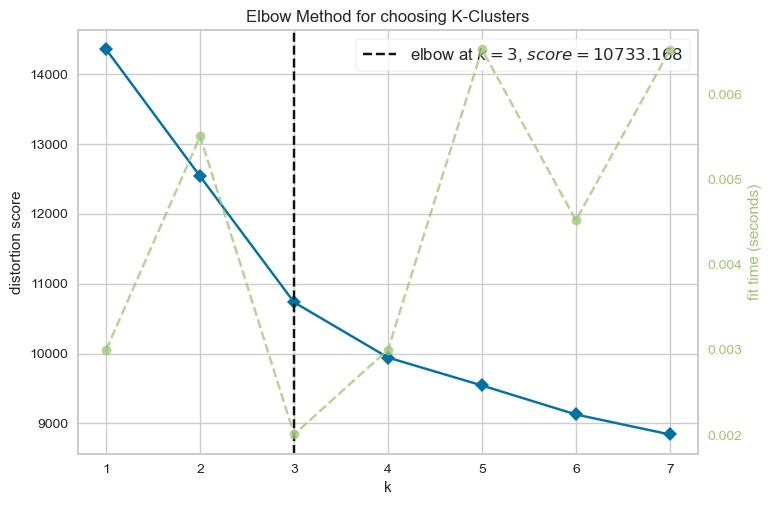

<Axes: title={'center': 'Elbow Method for choosing K-Clusters'}, xlabel='k', ylabel='distortion score'>

In [68]:
# In order to use K-Means clustering, first I want to use the elbow method to determine the optimal number of clusters

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8), timings=True)

# Fit the data to the visualizer
visualizer.fit(pca_data)
visualizer.title = 'Elbow Method for choosing K-Clusters'
visualizer.show()

In [69]:
# Fit KMeans Model using optimal number of clusters

kmeans = KMeans(n_clusters=4, random_state=0).fit(pca_data)

In [70]:
# Extract cluster centroids and put them into a data frame
centers = kmeans.cluster_centers_
centroids = pd.DataFrame(centers, columns=['PC1', 'PC2'])

# extract cluster labels

lab = kmeans.labels_

# Add cluster labels to pca_data
pca_data['cluster'] = lab

pca_data.head()

ValueError: Shape of passed values is (4, 15), indices imply (4, 2)

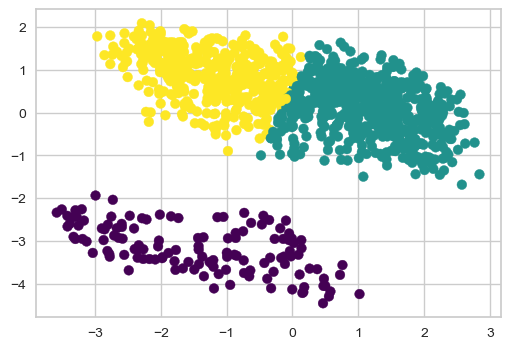

In [24]:
# Plot the labeled data 

fig, ax = plt.subplots(figsize=(6,4))

# Add data points

ax.scatter(x=pca_data['PC1'], y=pca_data['PC2'], c=pca_data['cluster'], cmap='viridis')
plt.show()
